# PROYECTO SEGMENTACIÓN DE IMAGENES

Este artefacto hace parte del entregable **La tarea de segmentación: Generación de paleta de colores a partir de imágenes con técnicas de machine learning no supervisado**, actividad de la asignatura de Machine Learning no Supervisado de la Maestria de Inteligencia Artificial de la Univerisdad de los Andes.

 Integrantes:
 - Jaime Alberto Rodriguez - 200717791
 - Yezid Alejandro Garcia - 200810710 

# ANALISIS DEL PROBLEMA - COMPRENSIÓN DEL NEGOCIO 

Se busca desarrollar un método automatizado que genere paletas de colores coherentes y atractivas a partir de los colores presentes en una imagen. Esto es útil para apoyar a profesionales creativos en la selección rápida y adecuada de colores, considerando no solo los tonos dominantes, sino también la armonía y relación entre ellos para lograr combinaciones visualmente agradables y funcionales.

## Selección de Algoritmos

Para garantizar el exito del proyecto se han seleccionado 3 algoritmos que si bien tienen como proposito la segmentación, tienen caracteristicas propias que seran de utilidad para para el procesamiento de disintos tipos de imagenes. Consideramos que el uso combinado o comparativo de estos algoritmos ofreceran distintas perspectivas y ventajas en la tarea de construir paletas de colores automáticas, abarcando diferentes características y requisitos de las imágenes que se procesen:

| __Algoritmo__ | __Descripción__ | __Ventaja Frente al Problema__ |
|-----------|-----------|-----------|
| K-means   |  Es uno de los algoritmos de clustering más populares y eficientes para la segmentación de datos en espacios métricos, como el de los colores.   | Permite extraer una representación condensada (centroides) de los tonos presentes en una imagen, lo que se traduce directamente en una paleta de colores relevante.   |
| K-Medoids   | s una estrategia robusta al ruido y a valores atípicos, ya que los “medoids” (representantes del grupo) siempre corresponden a datos reales del conjunto en vez de promedios (a diferencia de K-means).    | La robustez frente a outliers y la garantía de que los colores seleccionados existen en la imagen mejoran la representatividad y fidelidad de la paleta extraída.   |
| Fuzzy C-Means   | Permite a un mismo dato (píxel/color) pertenecer a más de un clúster con diferentes grados de pertenencia, reconociendo las transiciones suaves entre colores y la naturaleza difusa de los límites en la gama cromática.    | Incrementa la flexibilidad al modelar la convivencia de tonos cercanos y puede generar paletas que representen mejor las transiciones cromáticas presentes en la obra.    |

# RECOLECCION DE DATOS 

Para el desarrollo de presente proyecto se han tomado como base las siguientes imagenes del repositorio WikiArt de Kaggle, teniendo en cuenta en lo posible que sean de estilos, periodos y artistas distintos:


Gleizez, A. (1916). albert-gleizes_acrobats-1916.jpg. En WikiArt Dataset. Kaggle. https://www.kaggle.com/datasets/steubk/wikiart

Gleizez, A. (1914). albert-gleizes_portrait-of-igor-stravinsky-1914.jpg. En WikiArt Dataset. Kaggle. https://www.kaggle.com/datasets/steubk/wikiart

Palolo, A. (1992). antonio-palolo_untitled-1992.jpg. En WikiArt Dataset. Kaggle. https://www.kaggle.com/datasets/steubk/wikiart

Guanzhong, W. (2007). wu-guanzhong_houses-of-the-south-2007.jpg. En WikiArt Dataset. Kaggle. https://www.kaggle.com/datasets/steubk/wikiart

Beattie, B. (1973). basil-beattie_cause-and-effect-v-1973.jpg. En WikiArt Dataset. Kaggle. https://www.kaggle.com/datasets/steubk/wikiart

tworkov, J. (1964). jack-tworkov_june-21-1964.jpg. En WikiArt Dataset. Kaggle. https://www.kaggle.com/datasets/steubk/wikiart

# PROCESAMIENTO DE INFORMACIÓN - CLASES DE SOPORTE

Se realiza la importacion de las librerias necesarias para desarrollar el proyecto:


In [15]:
import cv2
import skfuzzy as fuzz

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin

In [16]:
SCALE_PERCENT = 35 # percent of original size

images_clustering = {
        "albert-gleizes_acrobats-1916.jpg": {
            "kmeans": None,
            "data": None
        },
        "albert-gleizes_portrait-of-igor-stravinsky-1914.jpg": {
            "kmeans": None,
            "data": None
        },
        "antonio-palolo_untitled-1992.jpg": {
            "kmeans": None,
            "data": None
        },
        "wu-guanzhong_houses-of-the-south-2007.jpg": {
            "kmeans": None,
            "data": None
        },
        "basil-beattie_cause-and-effect-v-1973.jpg": {
            "kmeans": None,
            "data": None
        },
        "jack-tworkov_june-21-1964.jpg": {
            "kmeans": None,
            "data": None
        },
}

Teniendo en cuenta que `Fuzzy C-Means` no hace parte de `Scikit-Learn`, se ha desarrollado una clase para adaptar el algoritmo y que sea compatible entre otras cosas con los Pipelines. Esto se logra al extender las clases `BaseEstimator` y `ClusterMixin`.

Los parametros de entrada principales de esta clase son:

- `n_clusters`: Número de clústeres a formar. Por defecto 3.
- `m`: Parámetro de difusividad (fuzziness). Por defecto 2.0.
- `max_iter`: Número máximo de iteraciones. Por defecto 150.
- `error`: Tolerancia para la convergencia. Por defecto 1e-5.
- `random_state`: Semilla para reproducibilidad. Por defecto `None`.


In [17]:
class FuzzyCMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=3, m=2.0, max_iter=150, error=1e-5, random_state=None):
        self.n_clusters = n_clusters
        self.m = m
        self.max_iter = max_iter
        self.error = error
        self.random_state = random_state

    def fit(self, X, y=None):
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            X.T, self.n_clusters, self.m, error=self.error, maxiter=self.max_iter, 
            init=None, seed=self.random_state
        )
        self.cntr_ = cntr
        self.u_ = u
        self.labels_ = np.argmax(u, axis=0)
        return self

    def predict(self, X):
        u, _, _, _, _, _ = fuzz.cluster.cmeans_predict(
            X.T, self.cntr_, self.m, error=self.error, maxiter=self.max_iter
        )
        return np.argmax(u, axis=0)

Adicionalmente se ha creado la clase utilitaria ImageUtilities que tiene como responsabilidades:
- Carga de imagenes desde la carpeta de ejecución del Notebook.
- Escala las imagenes a un porcentaje especifico.
- Opcionalmente muestra la imagen cargada y/o procesada, esto mas como una alternativa de debug.

Esta clase tambien se existiende de `BaseEstimator` y `TransformerMixin` para hacerla compatible con los Pipelines de Scikit-learn.

In [18]:
class ImageUtilities(BaseEstimator, TransformerMixin):
    def __init__(self, scale_percent=50):
        self.scale_percent = scale_percent
        print("Scalating images to {}% of original size".format(scale_percent))

    def fit(self, X, y=None):        
        return self
     
    def transform(self, X):        
        images = X
        for imageName in X.keys():
            try:
                full_image = self.loadImage(imageName)
                resized_image = self.resizeImage(full_image)
                images[imageName]['data'] = resized_image
            except Exception as e:
                print(f"Error loading image {imageName}: {e}")
                continue
        print("Loaded {} images".format(len(images)))        
        return images

    def loadImage(self, imageName):
        # Images are in the same directory as the notebook
        try:
            img = cv2.imread(imageName)
            if img is None:
                raise ValueError(f"Could not load image: {imageName}")
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            return img_rgb
        except Exception as e:
            print(f"Error in loadImage for {imageName}: {e}")
            raise

    def resizeImage(self, img):
        # Escalar la imagen al SP% de su tamaño original    
        width = int(img.shape[1] * self.scale_percent / 100)
        height = int(img.shape[0] * self.scale_percent / 100)
        dim = (width, height)
        img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)        
        return img
    
    def showImage(self, img):
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        print(img.shape)

A continuación se define otra clase utilitaria: **ImageSegmentationBenchmark**.

Esta clase implementa el proceso de comparación de algoritmos de segmentación (`KMeans`, `KMedoids`, `Fuzzy C-Means`) sobre un conjunto de imágenes y diferentes valores de `K` (número de clusters).

Recibe como parametros un rango de valores de `K` (inicial y maximo) asi como una lista de algoritmos a incluir en el Benchmarking.

Finalmente retorna para cada imagen y cada algoritmo, los valores del score de silueta. 

In [19]:
class ImageSegmentationBenchmark(BaseEstimator, TransformerMixin):
    def __init__(self, k_min, k_max, segmentationMethods, random_state=0):
        self.k_min = k_min
        self.k_max = k_max
        self.random_state = random_state
        self.segmentationMethods = segmentationMethods

    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X):
        images = X
        benchmark = []

        for image in images:   
            try:
                scaler = StandardScaler()
                original_image = images[image]['data'].copy()
                image_data = scaler.fit_transform(images[image]['data'].reshape((-1, 3)).astype(float)) 
                scores = []
                
                for method in self.segmentationMethods:    
                    for i in range(self.k_min, self.k_max+1):
                        print("Segmenting image {} with {} and k={}".format(image, method, i))                    
                        try:
                            if method == 'kmeans':
                                model = KMeans(n_clusters=i, random_state=self.random_state, max_iter=300, n_init=10)
                            elif method == 'kmedoids':
                                model = KMedoids(n_clusters=i, random_state=self.random_state, init='k-medoids++', max_iter=300)
                            elif method == 'fuzzy':
                                model = FuzzyCMeans(n_clusters=i, random_state=self.random_state)
                            else:
                                raise ValueError("Método no soportado: {}".format(method))
                            
                            model.fit(image_data)
                            
                            # Check if clustering is valid
                            if len(np.unique(model.labels_)) > 1:
                                score = silhouette_score(image_data, model.labels_)
                                scores.append((method, i, round(score, 3)))
                            else:
                                print(f"Warning: Only one cluster found for {method} k={i}")
                                scores.append((method, i, -1))  # Invalid score
                                
                        except Exception as e:
                            print(f"Error with {method} k={i}: {e}")
                            scores.append((method, i, -1))  # Error score

                benchmark.append((original_image, scores))
                
            except Exception as e:
                print(f"Error processing image {image}: {e}")
                continue
                
        return benchmark

A continuación se define otra clase utilitaria: **ImageSegmentationBenchmarkResult**.

El proposito de esta clase es mostrar los resultados obtenidos del proceso de benchmarking de segmentación de imágenes. Por cada imagen se genera el siguiente reporte:
- La imagen original.
- Gráfica del Silhouette Score por cada método y valor de `K`.
- Tabla con el valor máximo de Silhouette Score y el `K` asociado para cada método.

Se ha implementado el metodo de silueta como mecanismo de evaluación, pues lo consideramos mas confiable y menos propenso a confusiones al tener la posibilidad de listar e identificar la inercias de mayor peso. 

In [20]:
class ImageSegmentationBenchmarkResult(BaseEstimator, TransformerMixin):
    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X):
        for (image, scores) in X:
            df = pd.DataFrame(scores, columns=['Method', 'K', 'Silhouette Score'])
            # Crear figura con 3 columnas
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            
            # Mostrar imagen
            axes[0].imshow(image)
            axes[0].axis('off')
            axes[0].set_title('Imagen')
            
            # Graficar silhouette score por método
            for method in df['Method'].unique():
                subset = df[df['Method'] == method]
                axes[1].plot(subset['K'], subset['Silhouette Score'], marker='o', label=method)
            axes[1].set_xlabel('K')
            axes[1].set_ylabel('Silhouette Score')
            axes[1].set_title('Silhouette Score por Método')
            axes[1].legend()
            axes[1].grid(True)
            
            # Tabla con el valor máximo de cada método
            max_rows = []
            for method in df['Method'].unique():
                subset = df[df['Method'] == method]
                idx_max = subset['Silhouette Score'].idxmax()
                row = subset.loc[idx_max, ['Method', 'K', 'Silhouette Score']]
                max_rows.append(row)
            max_scores = pd.DataFrame(max_rows)


            axes[2].axis('off')
            table = axes[2].table(cellText=max_scores.values,
                                  colLabels=max_scores.columns,
                                  loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(12)
            
            axes[2].set_title('Máximo Silhouette Score')
            
            plt.tight_layout()
            plt.show()
        return X
        

A continuación se define un `Pipeline` que orquesta la ejecución de las clases utilitarias siguiendo los pasos funcionales:
- Carga y procesamiento de imagenes.
- Evaluación de algoritmos.
- Impresión del resultado de la evaluación.

El Pipeline recibe como parametro de entrada la lista de imagenes a procesar.

Scalating images to 35% of original size
Loaded 6 images
Segmenting image albert-gleizes_acrobats-1916.jpg with kmeans and k=4
Segmenting image albert-gleizes_acrobats-1916.jpg with kmeans and k=5
Segmenting image albert-gleizes_acrobats-1916.jpg with kmeans and k=6
Segmenting image albert-gleizes_acrobats-1916.jpg with kmeans and k=7
Segmenting image albert-gleizes_acrobats-1916.jpg with kmedoids and k=4
Segmenting image albert-gleizes_acrobats-1916.jpg with kmedoids and k=5
Segmenting image albert-gleizes_acrobats-1916.jpg with kmedoids and k=6
Segmenting image albert-gleizes_acrobats-1916.jpg with kmedoids and k=7
Segmenting image albert-gleizes_acrobats-1916.jpg with fuzzy and k=4
Segmenting image albert-gleizes_acrobats-1916.jpg with fuzzy and k=5
Segmenting image albert-gleizes_acrobats-1916.jpg with fuzzy and k=6
Segmenting image albert-gleizes_acrobats-1916.jpg with fuzzy and k=7
Segmenting image albert-gleizes_portrait-of-igor-stravinsky-1914.jpg with kmeans and k=4
Segmenting

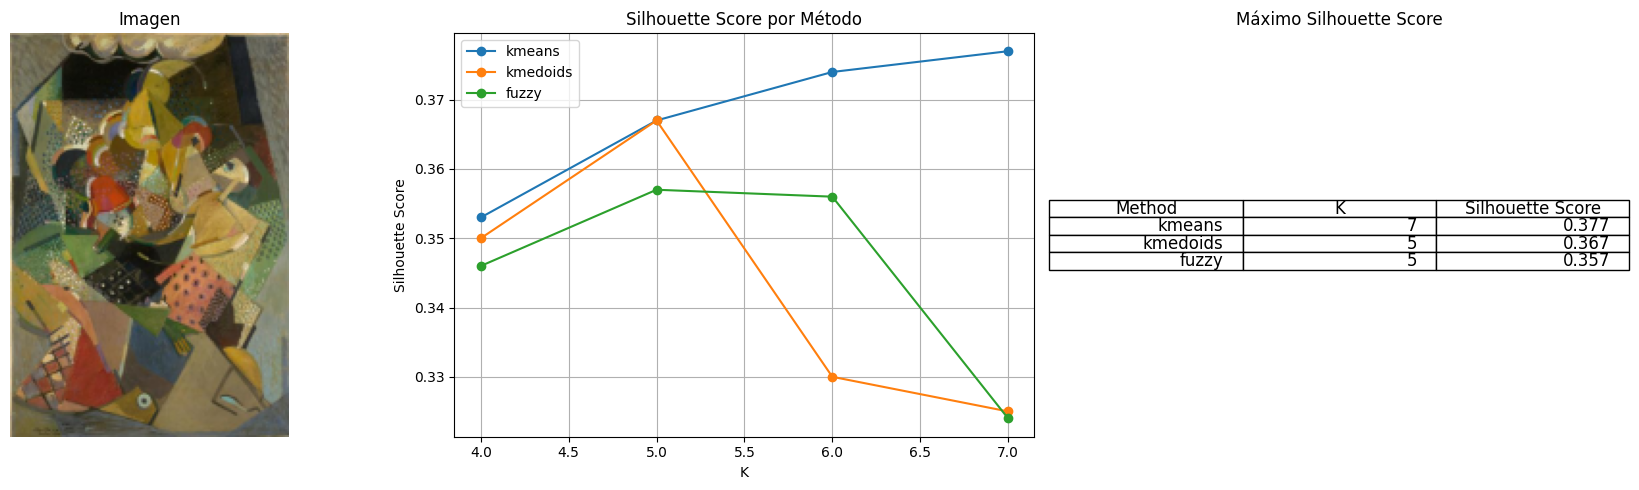

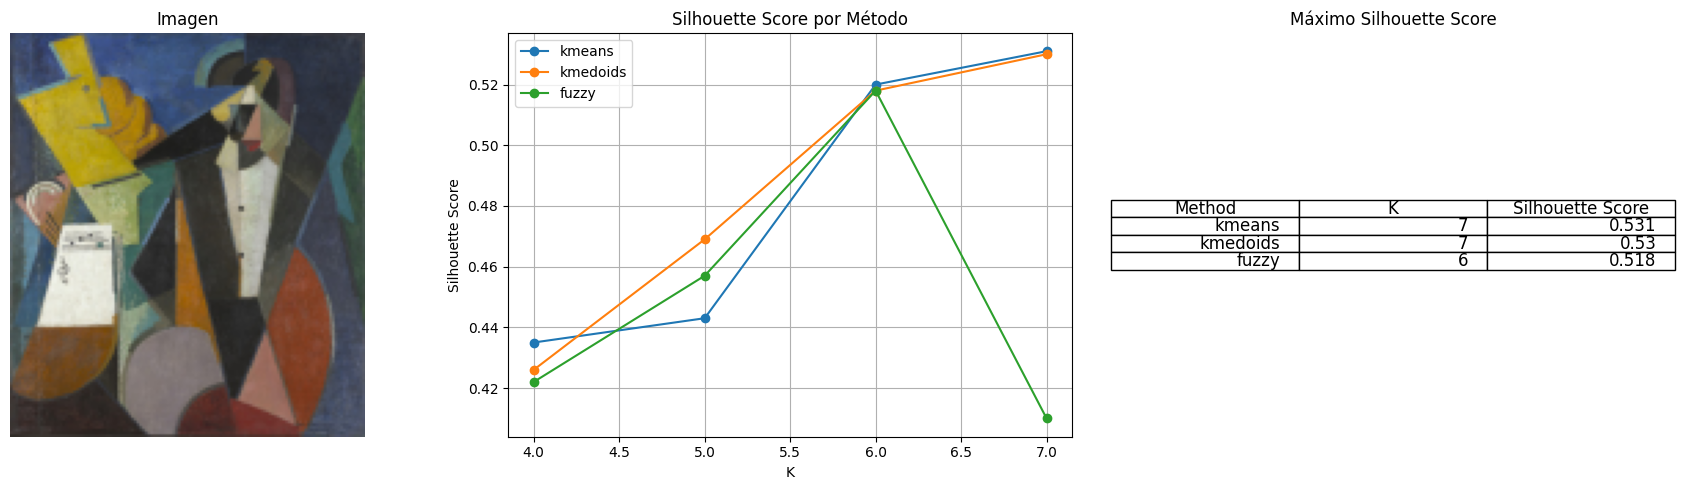

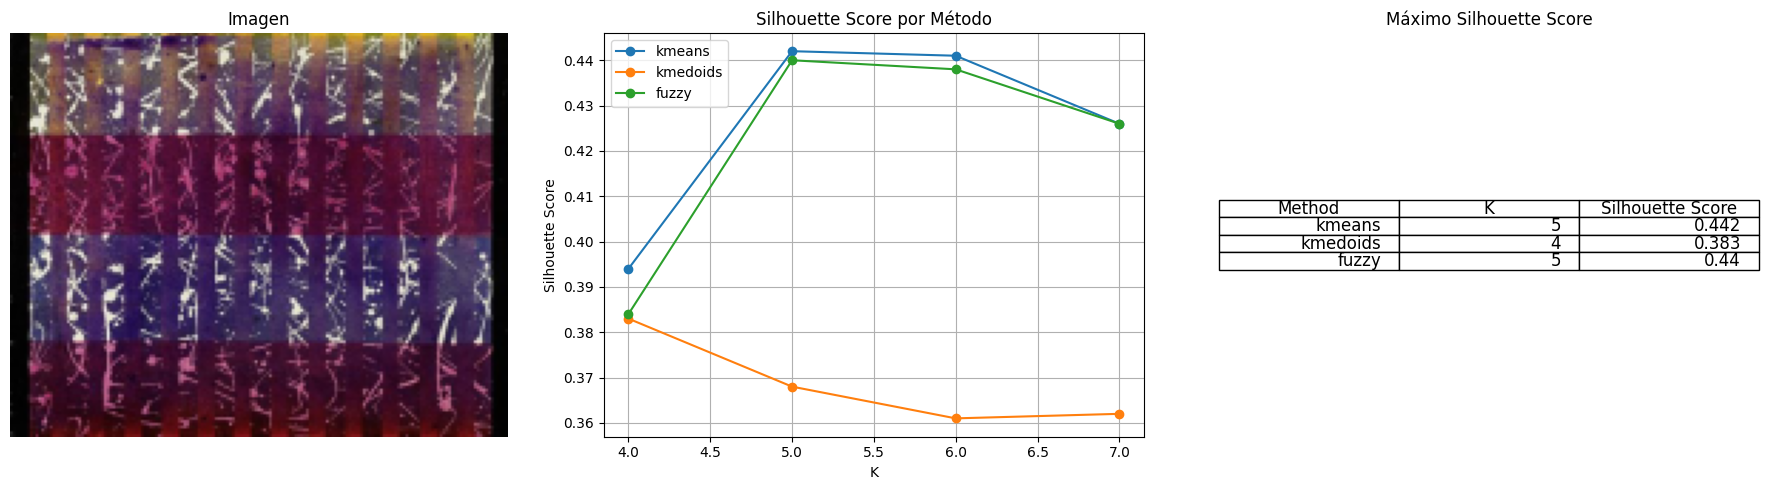

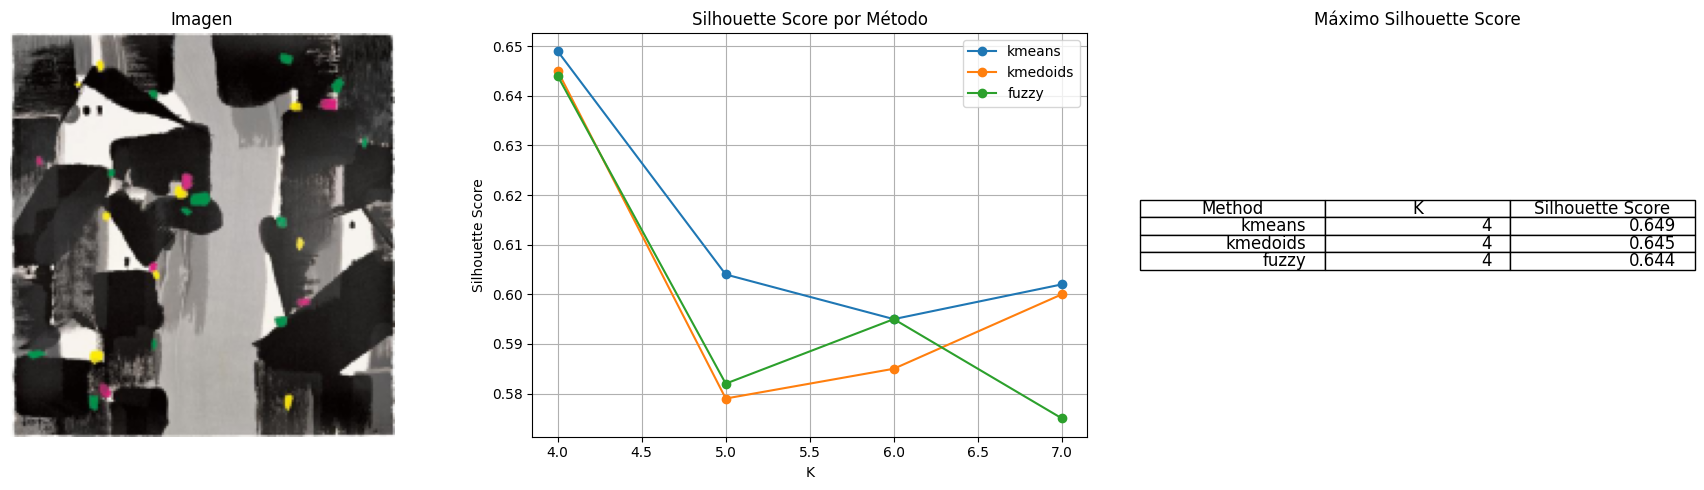

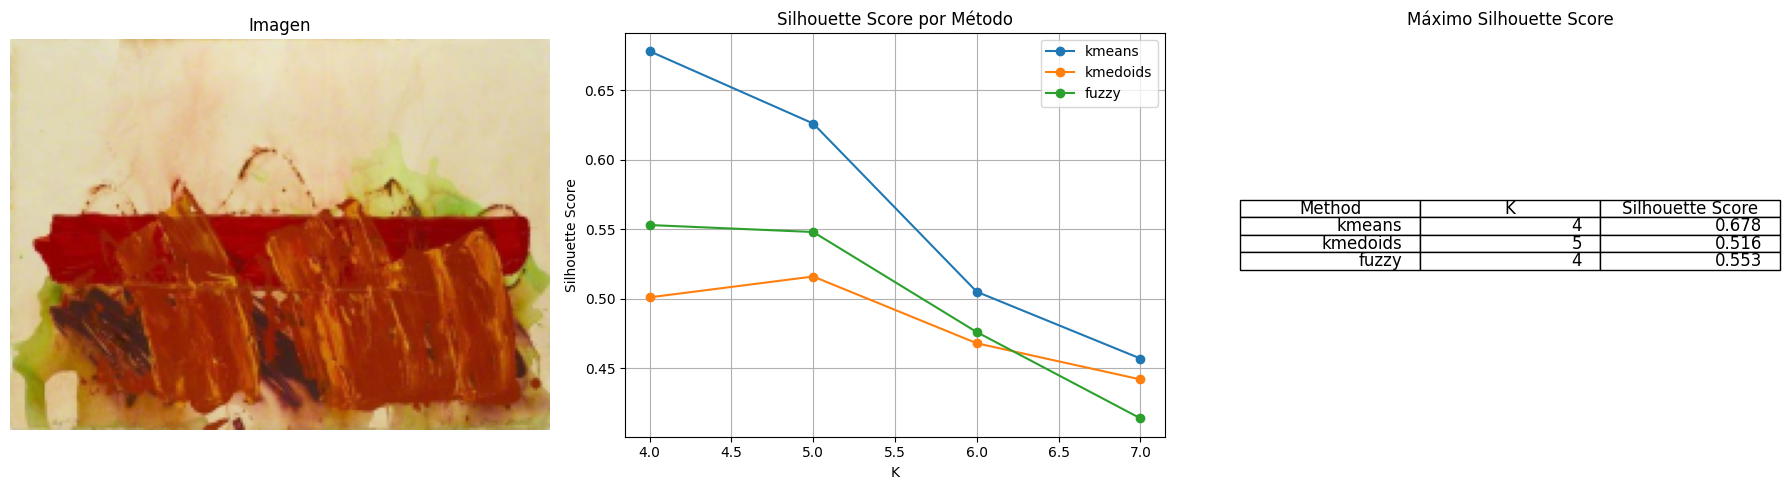

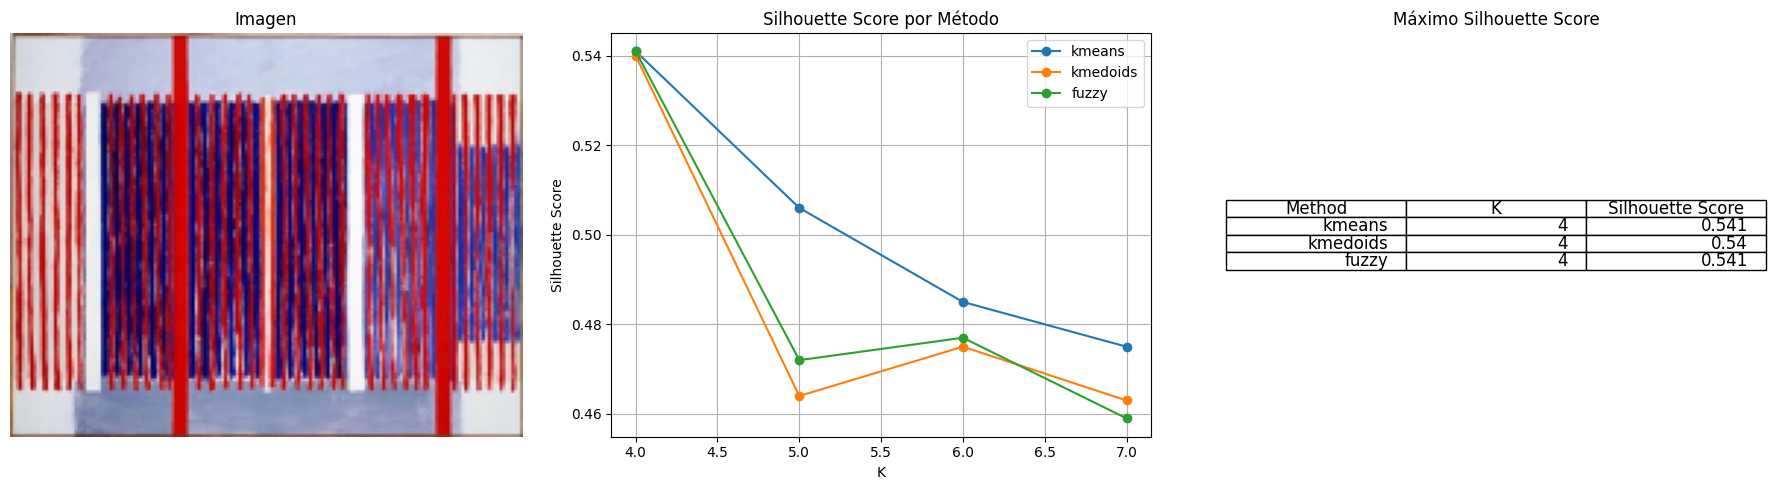

In [21]:
#imageNames = images_clustering['images'].values()

methods = ['kmeans', 'kmedoids', 'fuzzy']

pipe = Pipeline(steps=[
    ("image_load", ImageUtilities(scale_percent=SCALE_PERCENT)),
    ("image_segment_benchmark", ImageSegmentationBenchmark(k_min=4, k_max=7, segmentationMethods=methods, random_state=0)),
    ('image_segment_result', ImageSegmentationBenchmarkResult())
    ])

#images = pipe.fit_transform(imageNames)
images = pipe.fit_transform(images_clustering)

In [22]:
images_clustering["albert-gleizes_acrobats-1916.jpg"]['kmeans'] = 7
images_clustering["albert-gleizes_portrait-of-igor-stravinsky-1914.jpg"]['kmeans'] = 7
images_clustering["antonio-palolo_untitled-1992.jpg"]['kmeans'] = 5
images_clustering["wu-guanzhong_houses-of-the-south-2007.jpg"]['kmeans'] = 4
images_clustering["basil-beattie_cause-and-effect-v-1973.jpg"]['kmeans'] = 4
images_clustering["jack-tworkov_june-21-1964.jpg"]['kmeans'] = 4

A continuación se define la clase utilitaria: ColorPalette.

Esta clase permite generar y visualizar la paleta de colores dominante de una imagen utilizando los algoritmos y cantidad de clusters identificados en el paso anterior. os parametros de entrada principales de esta clase son:

- `method`: Algoritmo de clustering a utilizar (`'kmeans'`, `'kmedoids'`, `'fuzzy'`). Por defecto `'kmeans'`.
- `k`: Número de colores (clusters) a extraer. Por defecto 4.
- `sort_by_frequency`: Si es `True`, ordena los colores de la paleta por frecuencia. Por defecto `True`.


 Está diseñada para integrarse en pipelines de Scikit-learn, extendiendo `BaseEstimator` y `TransformerMixin`.

In [9]:
class ColorPalette(BaseEstimator, TransformerMixin):
    def __init__(self, method='kmeans', k=4, sort_by_frequency=True, figsize=(12, 4)):
        self.method = method
        self.k = k
        self.sort_by_frequency = sort_by_frequency
        self.figsize = figsize

    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X):
        images = X
        palette_results = []

        for image in images:
            self._adjust_k(images[image])
            palette_info = self._generate_single_palette(images[image]['data'], image)
            palette_results.append({
                'image': image,
                'palette': palette_info,
                'method_used': self.method,
                'k_used': self.k
            })
        
        return palette_results
    
    def _adjust_k(self, image):
        self.k = image[self.method]

    def _generate_single_palette(self, image, img_num):
        scaler = StandardScaler()
        image_data = scaler.fit_transform(image.reshape((-1, 3)).astype(float))
        
        # clustering
        if self.method == 'kmeans':
            model = KMeans(n_clusters=self.k, random_state=0, max_iter=300, n_init=10)
        elif self.method == 'kmedoids':
            model = KMedoids(n_clusters=self.k, random_state=0, init='k-medoids++', max_iter=300)
        elif self.method == 'fuzzy':
            model = FuzzyCMeans(n_clusters=self.k, random_state=0)
        else:
            raise ValueError(f"Unsupported method: {self.method}")
        
        model.fit(image_data)
        
        # silhouette score
        from sklearn.metrics import silhouette_score
        if len(np.unique(model.labels_)) > 1:
            silhouette_score_val = silhouette_score(image_data, model.labels_)
        else:
            silhouette_score_val = -1
        
        # Get centroids/medoids
        if hasattr(model, 'cluster_centers_'):
            centroids = model.cluster_centers_
        elif hasattr(model, 'cntr_'):
            centroids = model.cntr_
        else:
            centroids = model.cluster_centers_
        
        # back to 0-255 
        centroids_rgb = scaler.inverse_transform(centroids)
        centroids_rgb = np.clip(centroids_rgb, 0, 255).astype(int)
        
        # Calculate cluster frequencies
        unique_labels, counts = np.unique(model.labels_, return_counts=True)
        cluster_counts = dict(zip(unique_labels, counts))
        
        # sorting
        if self.sort_by_frequency:
            sorted_indices = np.argsort([cluster_counts.get(i, 0) for i in range(len(centroids_rgb))])[::-1]
            centroids_rgb = centroids_rgb[sorted_indices]
            sorted_counts = [cluster_counts.get(sorted_indices[i], 0) for i in range(len(centroids_rgb))]
        else:
            sorted_counts = [cluster_counts.get(i, 0) for i in range(len(centroids_rgb))]
        
        palette_info = {
            'centroids': centroids_rgb,
            'counts': sorted_counts,
            'method': self.method,
            'k': self.k,
            'silhouette_score': silhouette_score_val,
            'total_pixels': len(model.labels_)
        }
        
        self._plot_single_palette(palette_info, img_num, image)
        
        return palette_info
    
    def _plot_single_palette(self, palette_info, img_num, original_image):
        import matplotlib.patches as mpatches
        
        fig, axes = plt.subplots(1, 3, figsize=self.figsize)
        
        # Show original
        axes[0].imshow(original_image)
        axes[0].axis('off')
        axes[0].set_title(f'Original Image {img_num}')
        
        # Show color palette
        centroids = palette_info['centroids']
        counts = palette_info['counts']
        
        for i, (color, count) in enumerate(zip(centroids, counts)):
            axes[1].add_patch(mpatches.Rectangle((i, 0), 1, 1, color=color / 255))
        
        axes[1].set_xlim(0, len(centroids))
        axes[1].set_ylim(0, 1)
        axes[1].axis('off')
        axes[1].set_title(f'Color Palette ({palette_info["method"].title()}, k={palette_info["k"]})')
        
        # Show color information
        axes[2].axis('off')
        color_info = []
        for i, (color, count) in enumerate(zip(centroids, counts)):
            percentage = (count / palette_info['total_pixels']) * 100
            rgb_str = f"RGB({color[0]}, {color[1]}, {color[2]})"
            color_info.append([f"Color {i+1}", rgb_str, f"{count} ({percentage:.1f}%)"])
        
        table = axes[2].table(cellText=color_info,
                             colLabels=['Color', 'RGB Values', 'Frequency'],
                             loc='center',
                             cellLoc='left')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)
        axes[2].set_title(f'Color Details\nSilhouette: {palette_info["silhouette_score"]:.3f}')
        
        plt.tight_layout()
        plt.show()

A continuación se define la clase utilitaria: **PCAPlot**.

Esta clase permite visualizar la distribución de los colores de una imagen en un espacio reducido de componentes principales (PCA), coloreando cada punto según el clúster al que pertenece. Los parametros de entrada principales de esta clase son:

- `method`: Algoritmo de clustering a utilizar (`'kmeans'`, `'kmedoids'`, `'fuzzy'`). Por defecto `'kmeans'`.
- `k`: Número de clusters a utilizar. Por defecto 4.
- `n_components`: Número de componentes principales para la reducción de dimensionalidad. Por defecto 2.

Está diseñada para integrarse en pipelines de Scikit-learn, extendiendo `BaseEstimator` y `TransformerMixin`.


In [10]:
class PCAPlot(BaseEstimator, TransformerMixin):
    def __init__(self, method='kmeans', k=4, n_components=2, figsize=(15, 6), random_state=42):
        self.method = method
        self.k = k
        self.n_components = n_components
        self.figsize = figsize
        self.random_state = random_state

    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X):
        images = X
        pca_results = []
        
        for image in images:
            self._adjust_k(images[image])
            print(f"Generating PCA plot for image {image} using {self.method} with k={self.k}")
            
            pca_info = self._generate_single_pca(images[image]['data'], image)
            
            pca_results.append({
                'image': image,
                'pca_result': pca_info,
                'method_used': self.method,
                'k_used': self.k
            })
        
        return pca_results
    
    def _adjust_k(self, image):
        self.k = image[self.method]

    def _determine_components(self, data):
        if isinstance(self.n_components, int):
            return min(self.n_components, data.shape[1])
        elif isinstance(self.n_components, float) and 0 < self.n_components <= 1:
            pca_temp = PCA(random_state=self.random_state)
            pca_temp.fit(data)
            cumsum_var = np.cumsum(pca_temp.explained_variance_ratio_)
            n_comp = np.argmax(cumsum_var >= self.n_components) + 1
            return min(n_comp, data.shape[1])
        else:
            return 2  # Default fallback
    
    def _generate_single_pca(self, image, img_num):
        scaler = StandardScaler()
        image_data = scaler.fit_transform(image.reshape((-1, 3)).astype(float))
        
        # clustering
        if self.method == 'kmeans':
            model = KMeans(n_clusters=self.k, random_state=self.random_state, max_iter=300, n_init=10)
        elif self.method == 'kmedoids':
            model = KMedoids(n_clusters=self.k, random_state=self.random_state, init='k-medoids++', max_iter=300)
        elif self.method == 'fuzzy':
            model = FuzzyCMeans(n_clusters=self.k, random_state=self.random_state)
        else:
            raise ValueError(f"Unsupported method: {self.method}")
        
        model.fit(image_data)
        
        # silhouette score
        from sklearn.metrics import silhouette_score
        if len(np.unique(model.labels_)) > 1:
            silhouette_score_val = silhouette_score(image_data, model.labels_)
        else:
            silhouette_score_val = -1
        
        # Get centroids for colors
        if hasattr(model, 'cluster_centers_'):
            centroids = model.cluster_centers_
        elif hasattr(model, 'cntr_'):
            centroids = model.cntr_
        else:
            centroids = model.cluster_centers_
            
        centroids_rgb = scaler.inverse_transform(centroids)
        centroids_rgb = np.clip(centroids_rgb, 0, 255).astype(int) / 255.0  # Normalize for colors
        
        # PCA
        n_comp = self._determine_components(image_data)
        pca = PCA(n_components=n_comp, random_state=self.random_state)
        image_pca = pca.fit_transform(image_data)
        
        pca_info = {
            'pca_data': image_pca,
            'labels': model.labels_,
            'centroids_rgb': centroids_rgb,
            'explained_variance': pca.explained_variance_ratio_,
            'total_variance': sum(pca.explained_variance_ratio_),
            'method': self.method,
            'k': self.k,
            'silhouette_score': silhouette_score_val,
            'n_components_used': n_comp
        }
        
        self._plot_single_pca(pca_info, img_num, image)
        
        return pca_info
    
    def _plot_single_pca(self, pca_info, img_num, original_image):
        fig, axes = plt.subplots(1, 2, figsize=self.figsize)
        
        # original image
        axes[0].imshow(original_image)
        axes[0].axis('off')
        axes[0].set_title(f'Original Image {img_num}')
        
        # PCA Plot
        pca_data = pca_info['pca_data']
        labels = pca_info['labels']
        centroids_rgb = pca_info['centroids_rgb']
        
        # Plot with its corresponding color
        for i in range(pca_info['k']):
            cluster_mask = labels == i
            if np.any(cluster_mask):
                axes[1].scatter(pca_data[cluster_mask, 0], pca_data[cluster_mask, 1], 
                              c=[centroids_rgb[i]], alpha=0.6, s=20,
                              label=f'Cluster {i} (n={np.sum(cluster_mask)})')
        
        axes[1].set_xlabel(f'PC1 ({pca_info["explained_variance"][0]:.3f})')
        axes[1].set_ylabel(f'PC2 ({pca_info["explained_variance"][1]:.3f})')
        axes[1].set_title(f'PCA - {pca_info["method"].title()} (k={pca_info["k"]})\n'
                         f'Total Variance: {pca_info["total_variance"]:.3f}, '
                         f'Silhouette: {pca_info["silhouette_score"]:.3f}')
        axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

A continuación se define la clase utilitaria: **TSNEPlot**.

Esta clase permite visualizar la distribución de los colores de una imagen en un espacio bidimensional utilizando la técnica de t-SNE (t-distributed Stochastic Neighbor Embedding), coloreando cada punto según el clúster al que pertenece. Los parametros de entrada principales de esta clase son:

- `method`: Algoritmo de clustering a utilizar (`'kmeans'`, `'kmedoids'`, `'fuzzy'`). Por defecto `'kmeans'`.
- `k`: Número de clusters a utilizar. Por defecto 4.
- `figsize`: Tamaño de la figura para la visualización. Por defecto `(15, 6)`.
- `random_state`: Semilla para reproducibilidad. Por defecto 42.
- `perplexity`: Parámetro de t-SNE que controla el equilibrio entre la atención local y global. Por defecto 30.
- `n_iter`: Número de iteraciones para la optimización de t-SNE. Por defecto 1000.
- `learning_rate`: Tasa de aprendizaje para t-SNE. Por defecto 200.
- `early_exaggeration`: Factor de exageración inicial en t-SNE. Por defecto 12.

Está diseñada para integrarse en pipelines de Scikit-learn, extendiendo `BaseEstimator` y `TransformerMixin`.


In [11]:
class TSNEPlot(BaseEstimator, TransformerMixin):
    def __init__(self, method='kmeans', k=4, figsize=(15, 6), random_state=42,
                 perplexity=30, n_iter=1000, learning_rate=200, early_exaggeration=12):
        self.method = method
        self.k = k
        self.figsize = figsize
        self.random_state = random_state
        self.perplexity = perplexity
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.early_exaggeration = early_exaggeration

    def fit(self, X=None, y=None):
        return self
    
    #def transform(self, X):
    def transform(self, X):
        images = X
        tsne_results = []
        
        for image in images:
            self._adjust_k(images[image])
            tsne_info = self._generate_single_tsne(images[image]['data'], image)
            tsne_results.append({
                'image': image,
                'tsne_result': tsne_info,
                'method_used': self.method,
                'k_used': self.k
            })
        
        return tsne_results
    
    def _adjust_k(self, image):
        self.k = image[self.method]

    def _generate_single_tsne(self, image, img_num):
        scaler = StandardScaler()
        image_data = scaler.fit_transform(image.reshape((-1, 3)).astype(float))
        
        # clustering
        if self.method == 'kmeans':
            model = KMeans(n_clusters=self.k, random_state=self.random_state, max_iter=300, n_init=10)
        elif self.method == 'kmedoids':
            model = KMedoids(n_clusters=self.k, random_state=self.random_state, init='k-medoids++', max_iter=300)
        elif self.method == 'fuzzy':
            model = FuzzyCMeans(n_clusters=self.k, random_state=self.random_state)
        else:
            raise ValueError(f"Unsupported method: {self.method}")
        
        model.fit(image_data)
        
        # silhouette score
        from sklearn.metrics import silhouette_score
        if len(np.unique(model.labels_)) > 1:
            silhouette_score_val = silhouette_score(image_data, model.labels_)
        else:
            silhouette_score_val = -1
        
        # Get centroids for colors
        if hasattr(model, 'cluster_centers_'):
            centroids = model.cluster_centers_
        elif hasattr(model, 'cntr_'):
            centroids = model.cntr_
        else:
            centroids = model.cluster_centers_
            
        centroids_rgb = scaler.inverse_transform(centroids)
        centroids_rgb = np.clip(centroids_rgb, 0, 255).astype(int) / 255.0  # Normalize for colors
        
        # Prepare data for t-SNE (reduce dimensionality first if needed)
        data_for_tsne = image_data
        pca_applied = False
        
        # If data is high-dimensional, apply PCA first to speed up t-SNE
        if image_data.shape[1] > 50:
            print("Applying PCA preprocessing for t-SNE...")
            pca_pre = PCA(n_components=50, random_state=self.random_state)
            data_for_tsne = pca_pre.fit_transform(image_data)
            pca_applied = True
            pca_variance = sum(pca_pre.explained_variance_ratio_)
        else:
            pca_variance = 1.0
        
        # Apply t-SNE
        adjusted_perplexity = min(self.perplexity, (len(image_data) - 1) // 3)  # Adjust if needed
        tsne = TSNE(
            n_components=2,
            random_state=self.random_state,
            perplexity=adjusted_perplexity,
            n_iter=self.n_iter,
            learning_rate=self.learning_rate,
            early_exaggeration=self.early_exaggeration,
            verbose=1
        )
        
        image_tsne = tsne.fit_transform(data_for_tsne)
        
        tsne_info = {
            'tsne_data': image_tsne,
            'labels': model.labels_,
            'centroids_rgb': centroids_rgb,
            'method': self.method,
            'k': self.k,
            'silhouette_score': silhouette_score_val,
            'pca_applied': pca_applied,
            'pca_variance': pca_variance if pca_applied else None,
            'perplexity_used': adjusted_perplexity
        }
        
        self._plot_single_tsne(tsne_info, img_num, image)
        
        return tsne_info
    
    def _plot_single_tsne(self, tsne_info, img_num, original_image):
        fig, axes = plt.subplots(1, 2, figsize=self.figsize)
        
        # Show original image
        axes[0].imshow(original_image)
        axes[0].axis('off')
        axes[0].set_title(f'Original Image {img_num}')
        
        # t-SNE Plot
        tsne_data = tsne_info['tsne_data']
        labels = tsne_info['labels']
        centroids_rgb = tsne_info['centroids_rgb']
        
        # Plot each cluster with its corresponding color
        for i in range(tsne_info['k']):
            cluster_mask = labels == i
            if np.any(cluster_mask):
                axes[1].scatter(tsne_data[cluster_mask, 0], tsne_data[cluster_mask, 1], 
                              c=[centroids_rgb[i]], alpha=0.6, s=20,
                              label=f'Cluster {i} (n={np.sum(cluster_mask)})')
        
        axes[1].set_xlabel('t-SNE 1')
        axes[1].set_ylabel('t-SNE 2')
        
        title = f't-SNE - {tsne_info["method"].title()} (k={tsne_info["k"]})\n'
        title += f'Silhouette: {tsne_info["silhouette_score"]:.3f}'
        if tsne_info['pca_applied']:
            title += f'\nPCA pre-processing (var: {tsne_info["pca_variance"]:.3f})'
        
        axes[1].set_title(title)
        axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print t-SNE info
        print(f"t-SNE completed:")
        print(f"  - Perplexity used: {tsne_info['perplexity_used']}")
        if tsne_info['pca_applied']:
            print(f"  - PCA pre-processing applied (variance retained: {tsne_info['pca_variance']:.3f})")

Scalating images to 35% of original size
=== K-Means Color Palette === ['albert-gleizes_acrobats-1916.jpg', 'albert-gleizes_portrait-of-igor-stravinsky-1914.jpg', 'antonio-palolo_untitled-1992.jpg', 'wu-guanzhong_houses-of-the-south-2007.jpg', 'basil-beattie_cause-and-effect-v-1973.jpg', 'jack-tworkov_june-21-1964.jpg']
Loaded 6 images


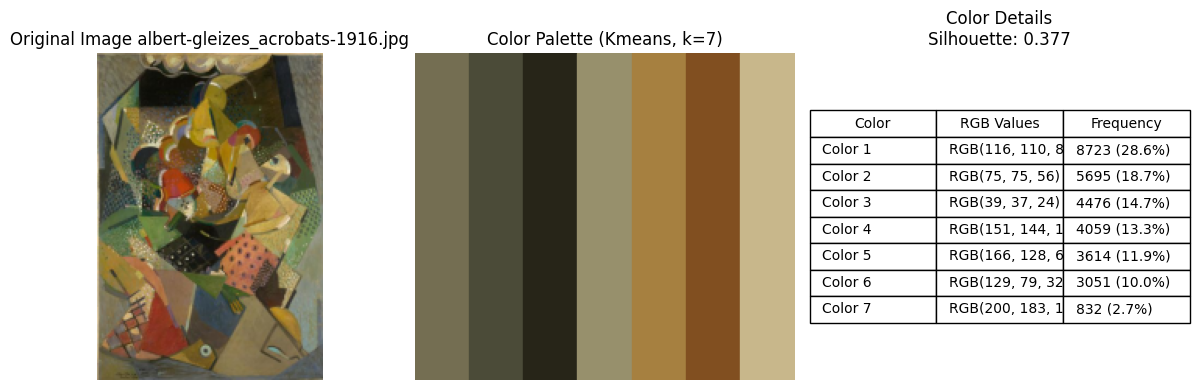

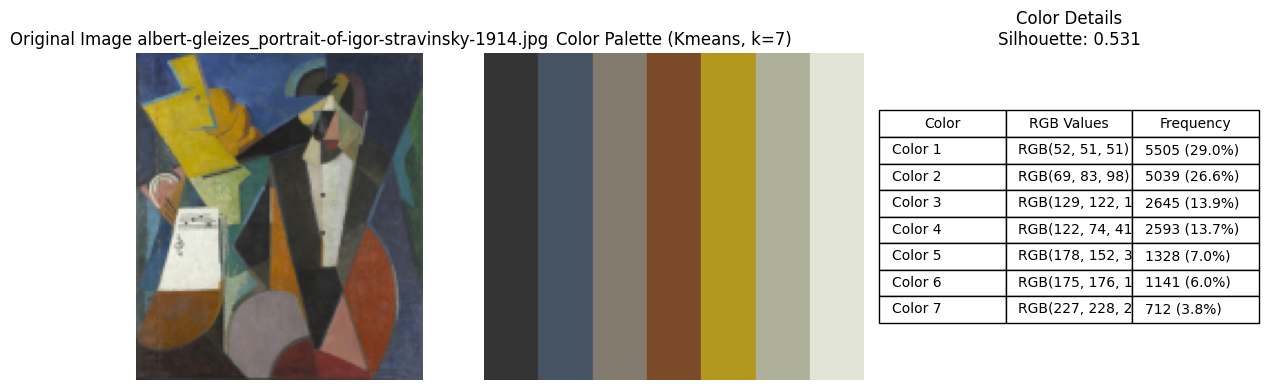

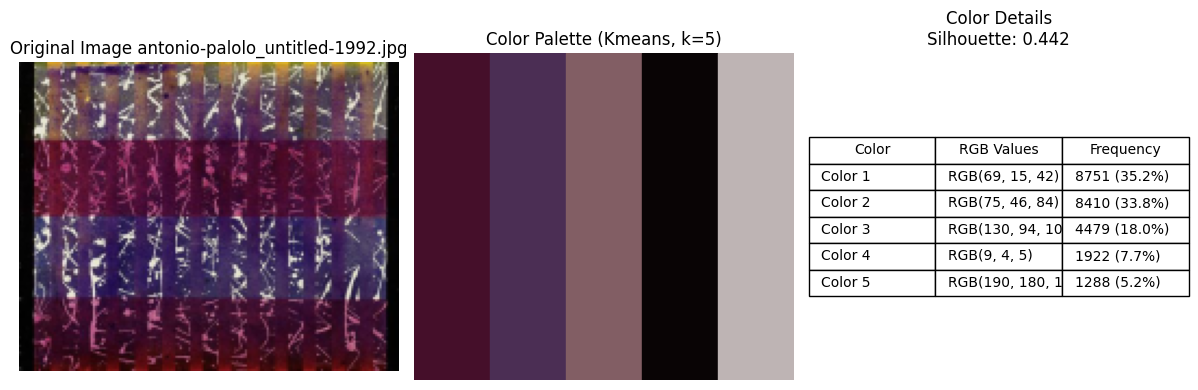

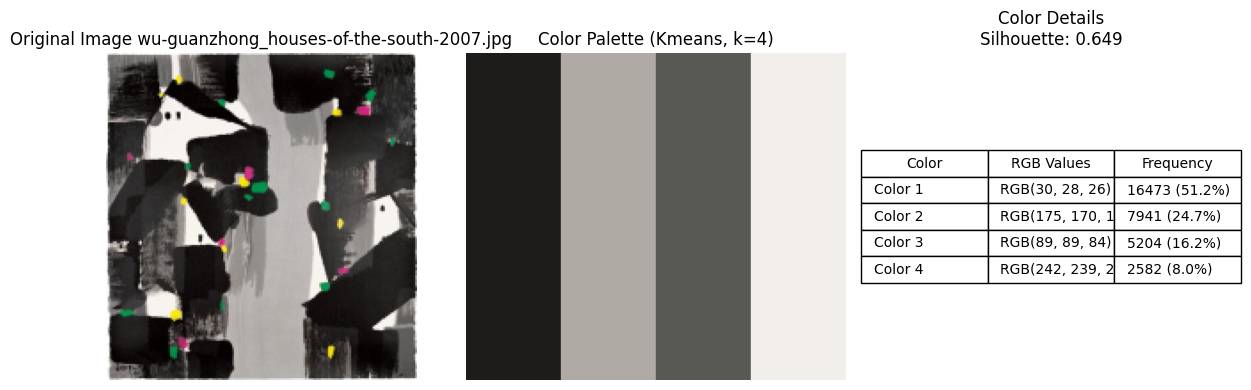

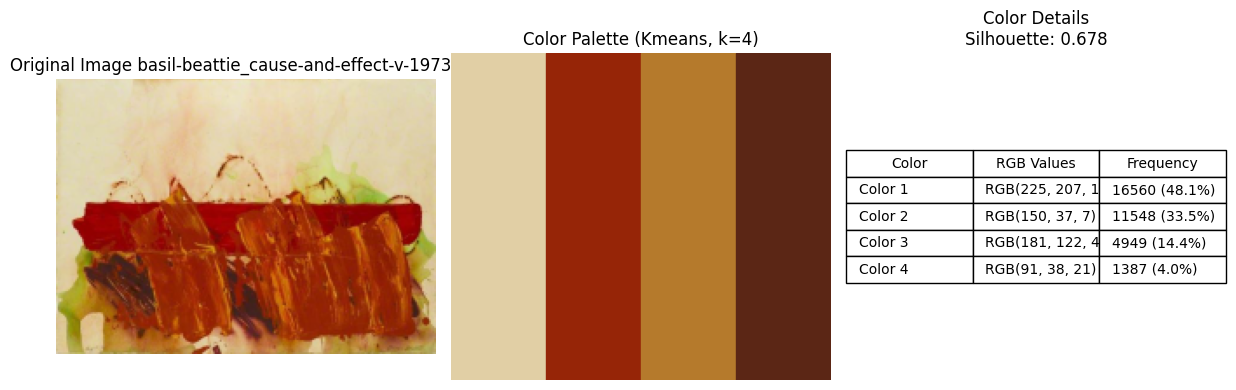

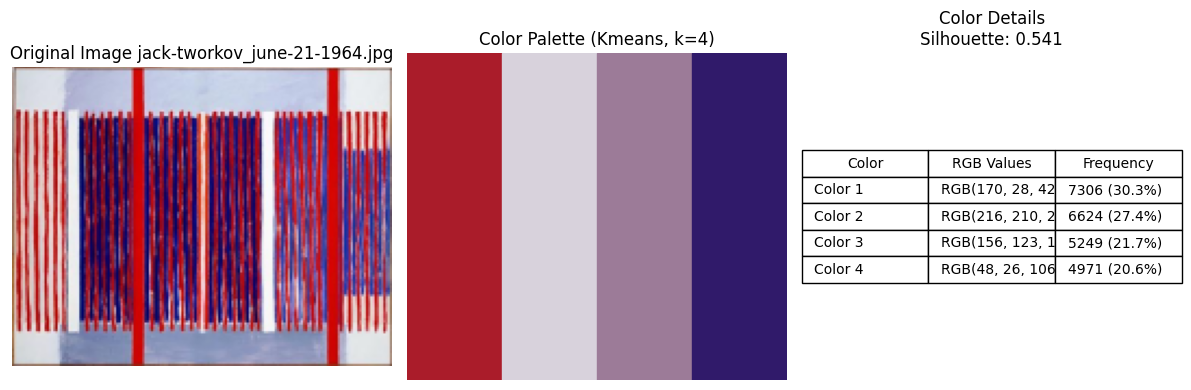

K-Means palette completed successfully


In [23]:
kmeans_palette_pipeline = Pipeline(
    steps=[("image_load", ImageUtilities(scale_percent=SCALE_PERCENT)),
           ('color_palette',
            ColorPalette(method='kmeans', sort_by_frequency=True))])

print("=== K-Means Color Palette ===", list(images_clustering))
kmeans_results = kmeans_palette_pipeline.fit_transform(images_clustering)
print("K-Means palette completed successfully")

Scalating images to 35% of original size
=== K-Means PCA Visualization ===
Loaded 6 images
Generating PCA plot for image albert-gleizes_acrobats-1916.jpg using kmeans with k=7


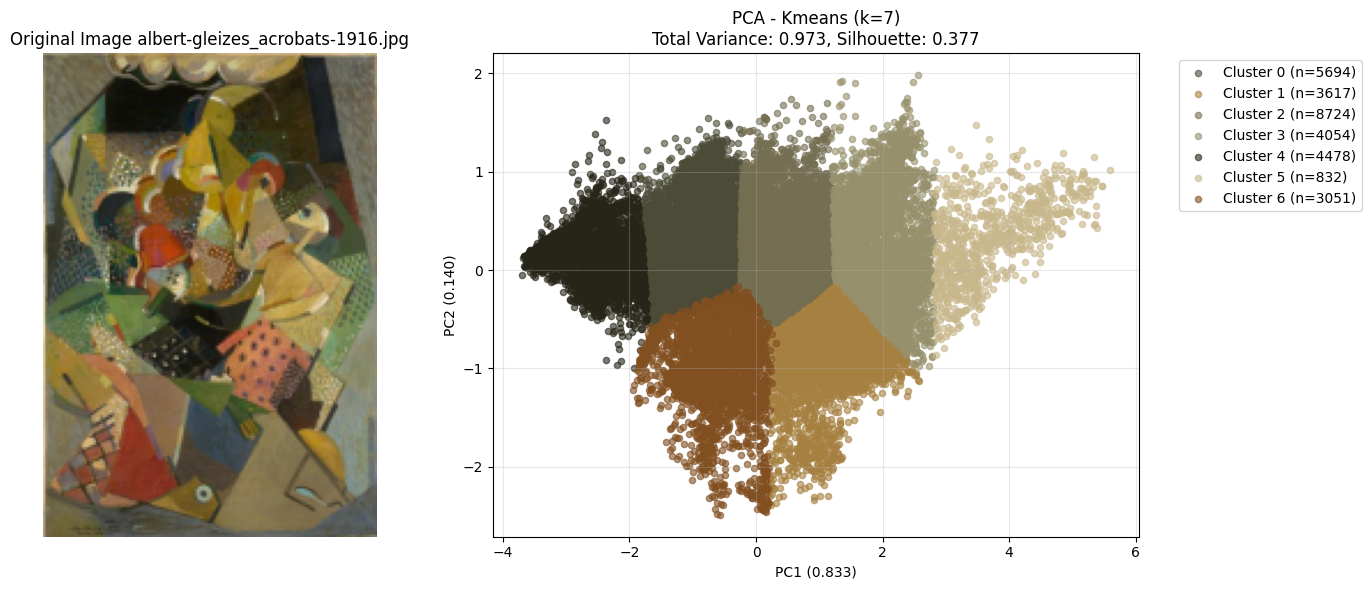

Generating PCA plot for image albert-gleizes_portrait-of-igor-stravinsky-1914.jpg using kmeans with k=7


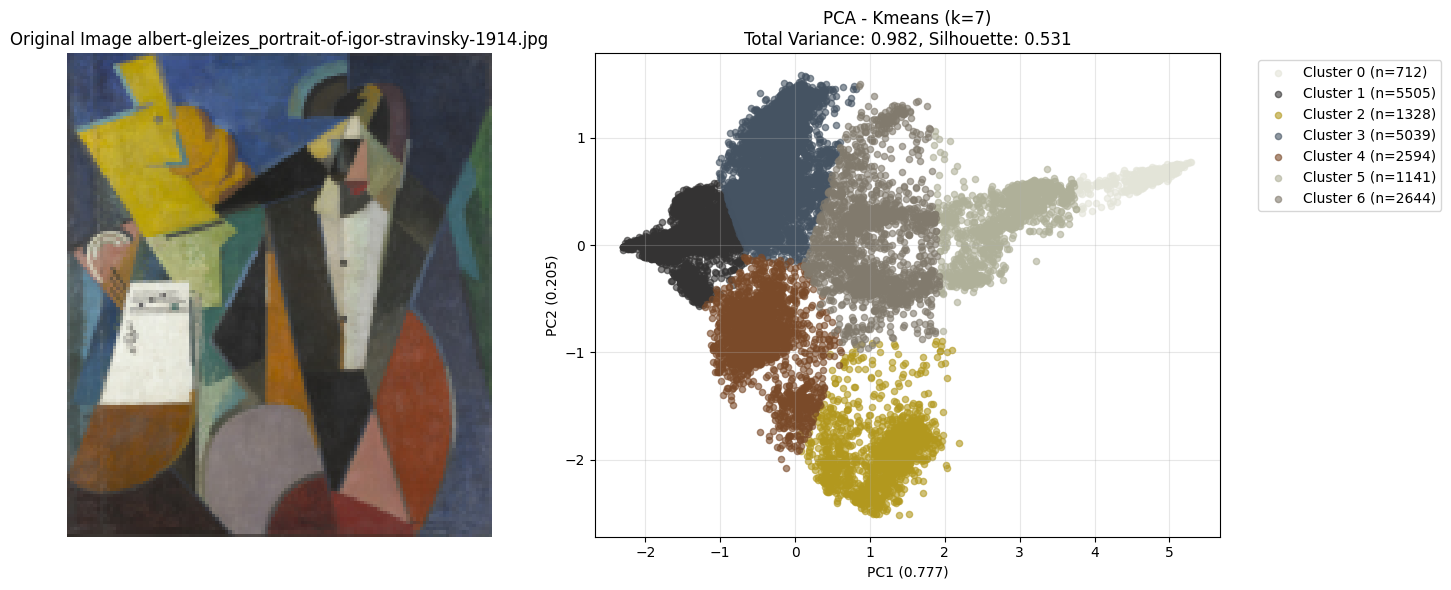

Generating PCA plot for image antonio-palolo_untitled-1992.jpg using kmeans with k=5


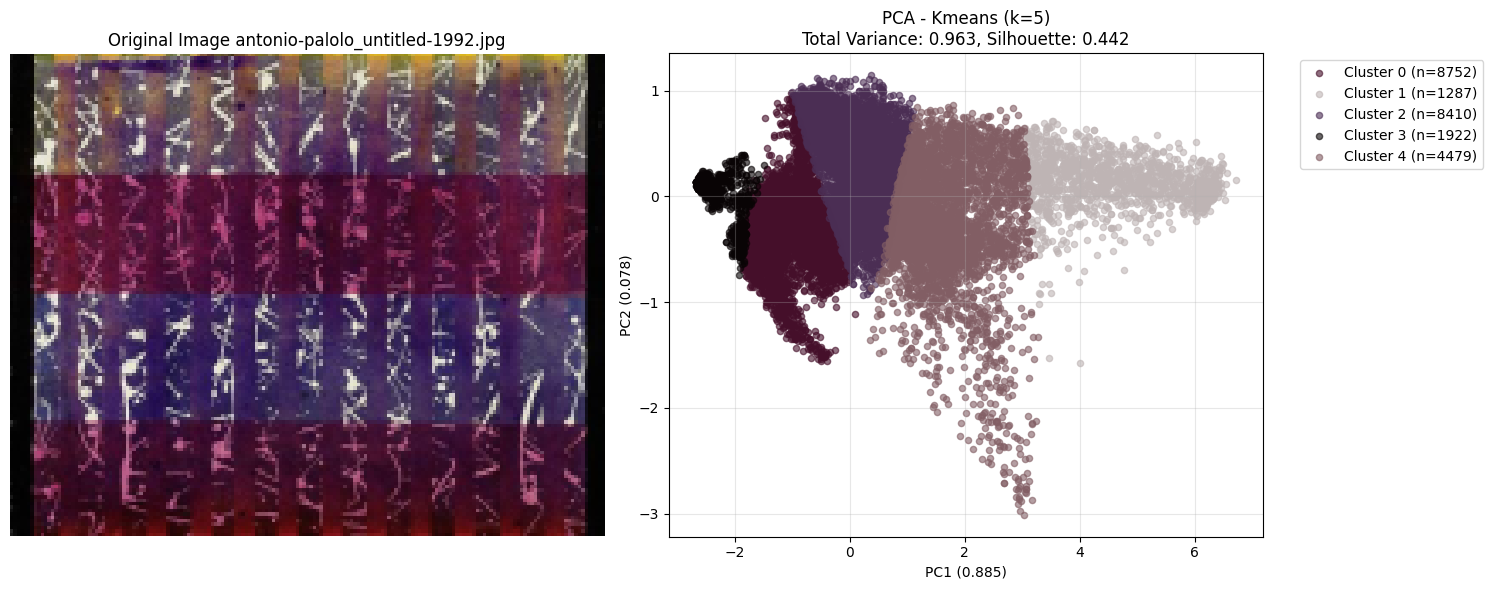

Generating PCA plot for image wu-guanzhong_houses-of-the-south-2007.jpg using kmeans with k=4


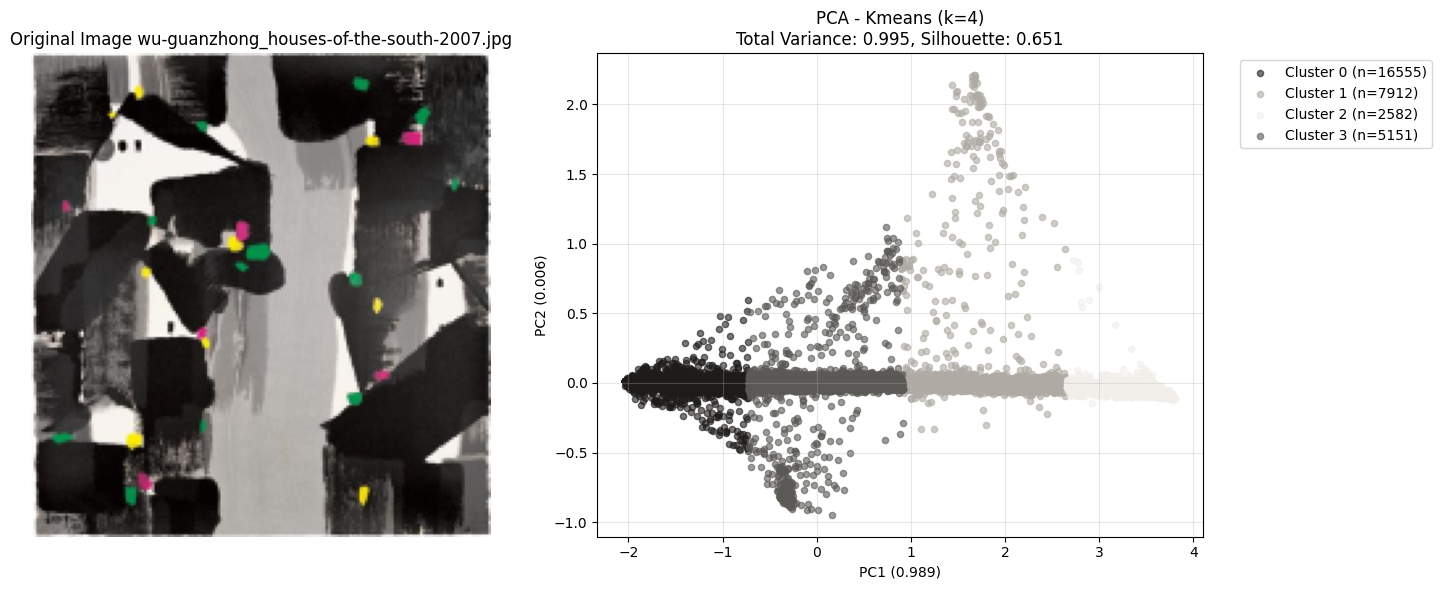

Generating PCA plot for image basil-beattie_cause-and-effect-v-1973.jpg using kmeans with k=4


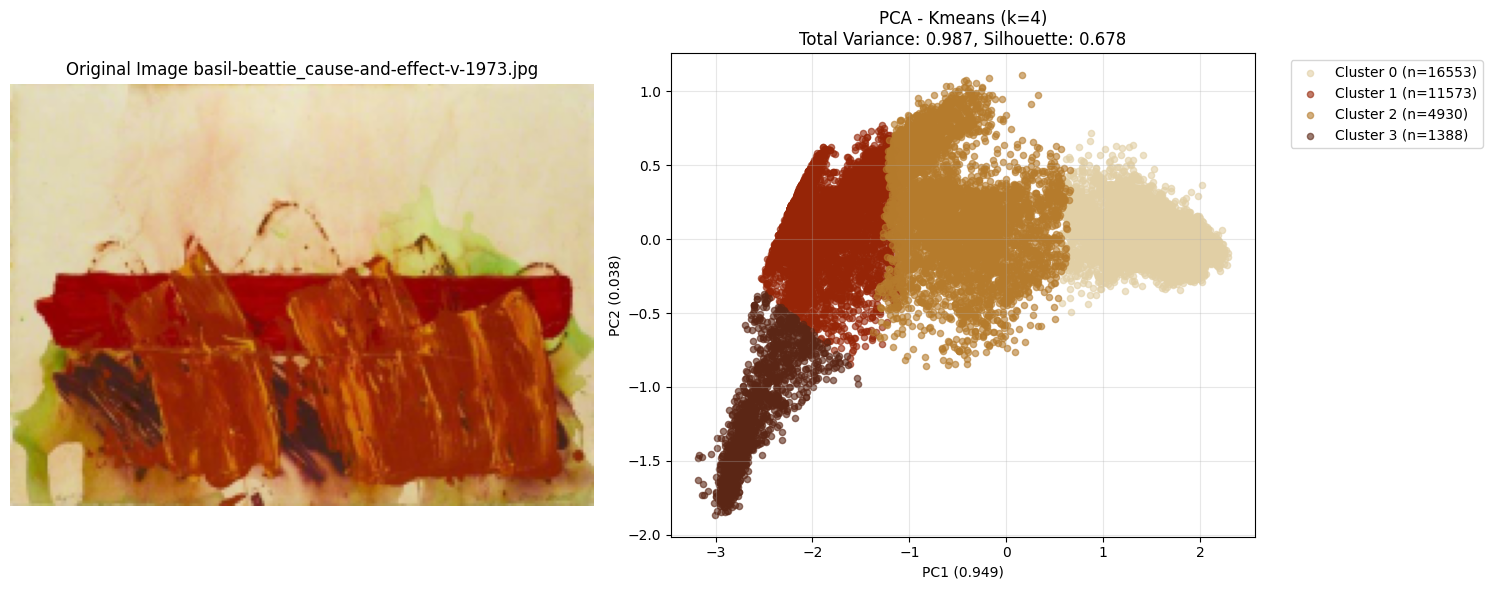

Generating PCA plot for image jack-tworkov_june-21-1964.jpg using kmeans with k=4


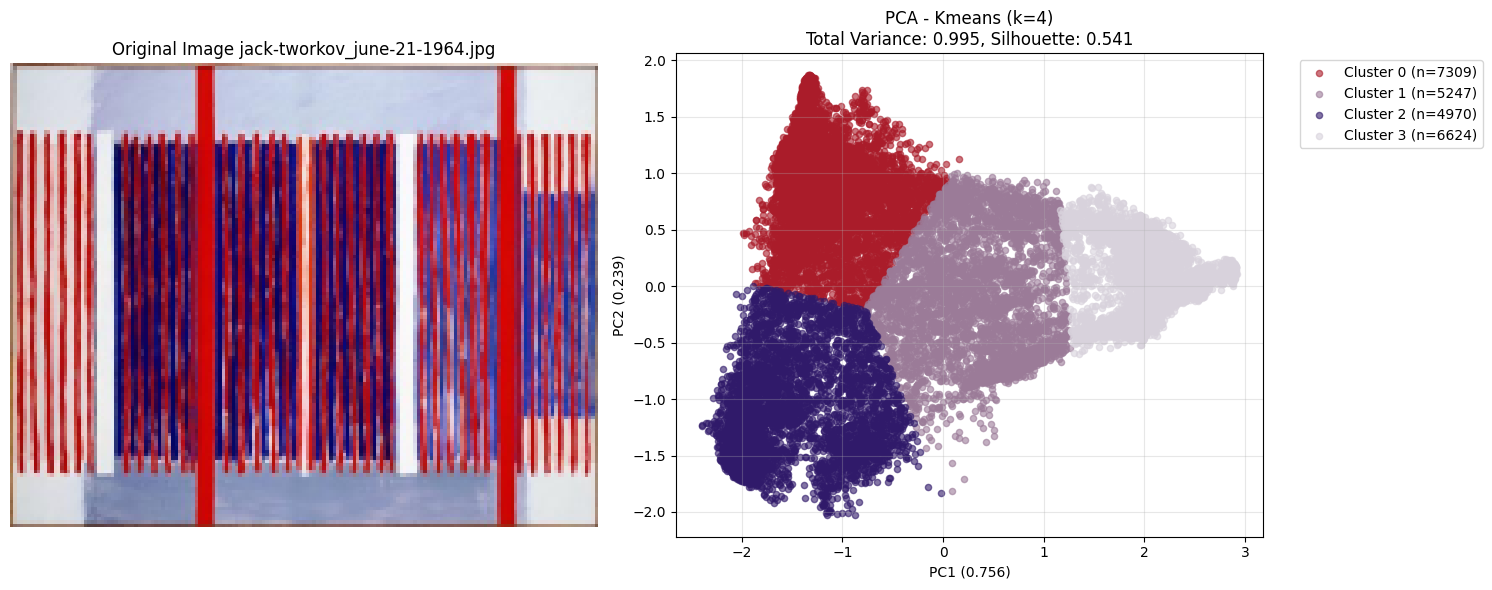

K-Means PCA completed successfully


In [24]:
kmeans_pca_pipeline = Pipeline(
    steps=[("image_load", ImageUtilities(scale_percent=SCALE_PERCENT)
            ), ('pca_plot', PCAPlot(method='kmeans', n_components=2))])

print("=== K-Means PCA Visualization ===")
kmeans_pca_results = kmeans_pca_pipeline.fit_transform(images_clustering)
print("K-Means PCA completed successfully")


Scalating images to 35% of original size
=== K-Means t-SNE Visualization ===
Loaded 6 images


/Users/I864098/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30450 samples in 0.007s...
[t-SNE] Computed neighbors for 30450 samples in 0.310s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30450
[t-SNE] Computed conditional probabilities for sample 2000 / 30450
[t-SNE] Computed conditional probabilities for sample 3000 / 30450
[t-SNE] Computed conditional probabilities for sample 4000 / 30450
[t-SNE] Computed conditional probabilities for sample 5000 / 30450
[t-SNE] Computed conditional probabilities for sample 6000 / 30450
[t-SNE] Computed conditional probabilities for sample 7000 / 30450
[t-SNE] Computed conditional probabilities for sample 8000 / 30450
[t-SNE] Computed conditional probabilities for sample 9000 / 30450
[t-SNE] Computed conditional probabilities for sample 10000 / 30450
[t-SNE] Computed conditional probabilities for sample 11000 / 30450
[t-SNE] Computed conditional probabilities for sample 12000 / 30450
[t-SNE] Computed conditional probabilities for sam

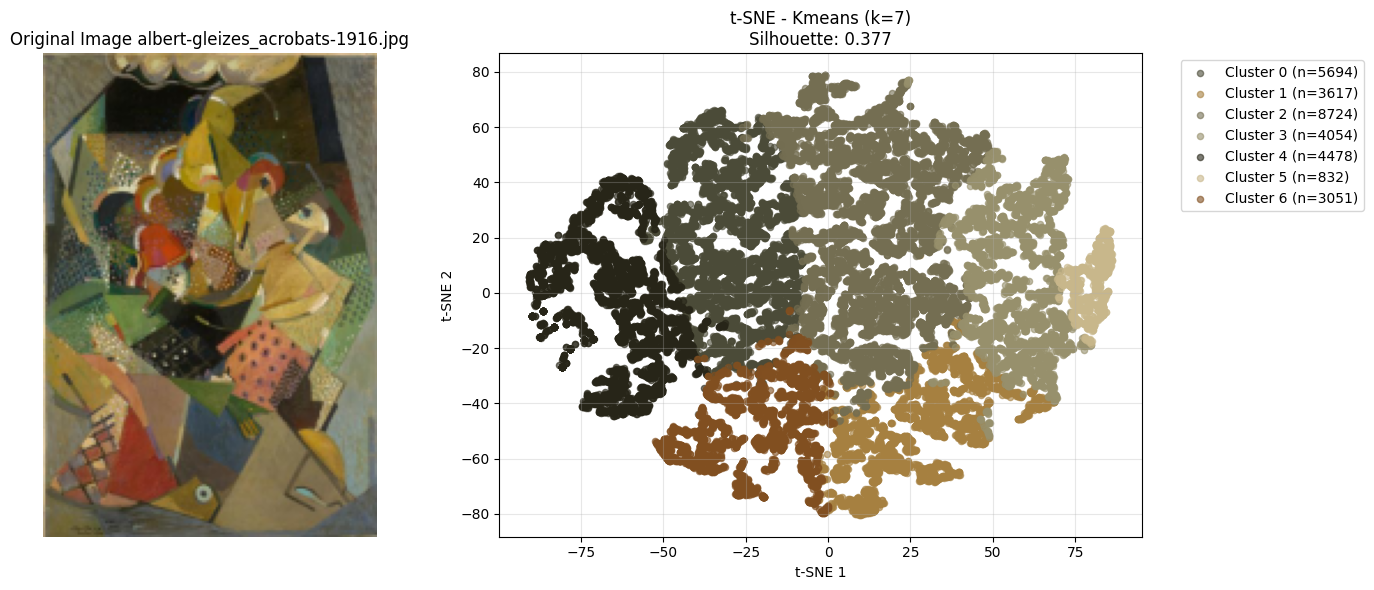

t-SNE completed:
  - Perplexity used: 30


/Users/I864098/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18963 samples in 0.003s...
[t-SNE] Computed neighbors for 18963 samples in 0.153s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18963
[t-SNE] Computed conditional probabilities for sample 2000 / 18963
[t-SNE] Computed conditional probabilities for sample 3000 / 18963
[t-SNE] Computed conditional probabilities for sample 4000 / 18963
[t-SNE] Computed conditional probabilities for sample 5000 / 18963
[t-SNE] Computed conditional probabilities for sample 6000 / 18963
[t-SNE] Computed conditional probabilities for sample 7000 / 18963
[t-SNE] Computed conditional probabilities for sample 8000 / 18963
[t-SNE] Computed conditional probabilities for sample 9000 / 18963
[t-SNE] Computed conditional probabilities for sample 10000 / 18963
[t-SNE] Computed conditional probabilities for sample 11000 / 18963
[t-SNE] Computed conditional probabilities for sample 12000 / 18963
[t-SNE] Computed conditional probabilities for sam

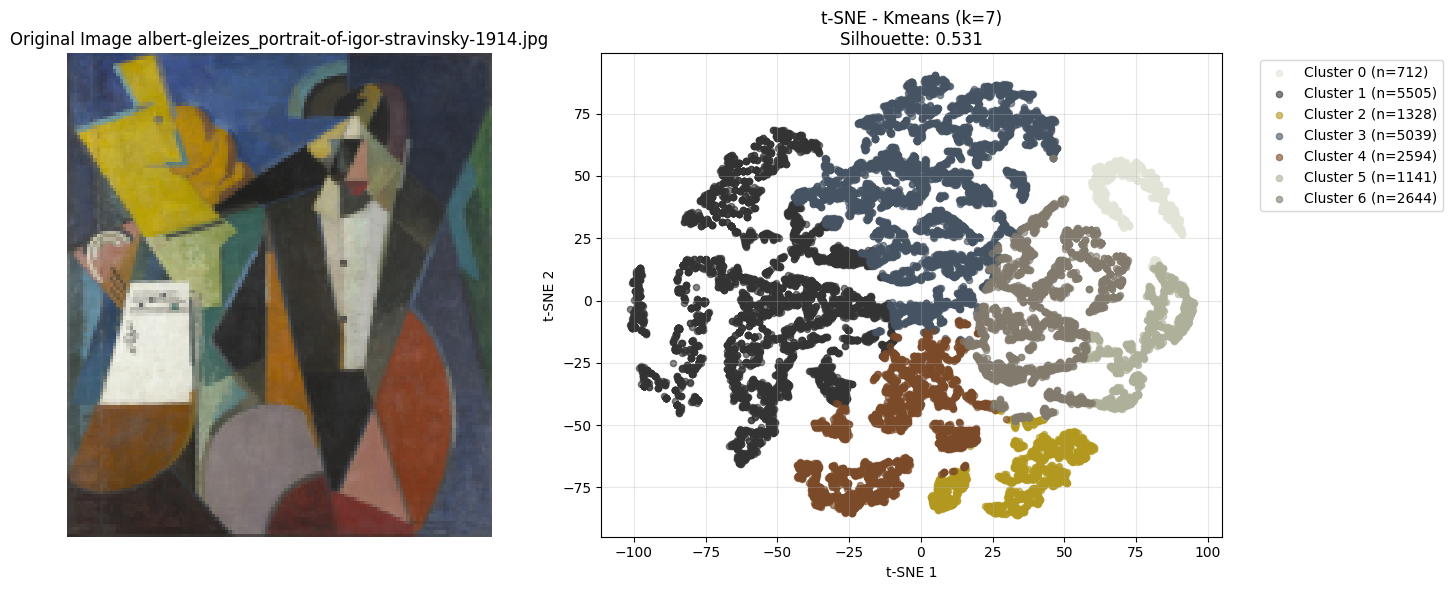

t-SNE completed:
  - Perplexity used: 30


/Users/I864098/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 24850 samples in 0.003s...
[t-SNE] Computed neighbors for 24850 samples in 0.244s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24850
[t-SNE] Computed conditional probabilities for sample 2000 / 24850
[t-SNE] Computed conditional probabilities for sample 3000 / 24850
[t-SNE] Computed conditional probabilities for sample 4000 / 24850
[t-SNE] Computed conditional probabilities for sample 5000 / 24850
[t-SNE] Computed conditional probabilities for sample 6000 / 24850
[t-SNE] Computed conditional probabilities for sample 7000 / 24850
[t-SNE] Computed conditional probabilities for sample 8000 / 24850
[t-SNE] Computed conditional probabilities for sample 9000 / 24850
[t-SNE] Computed conditional probabilities for sample 10000 / 24850
[t-SNE] Computed conditional probabilities for sample 11000 / 24850
[t-SNE] Computed conditional probabilities for sample 12000 / 24850
[t-SNE] Computed conditional probabilities for sam

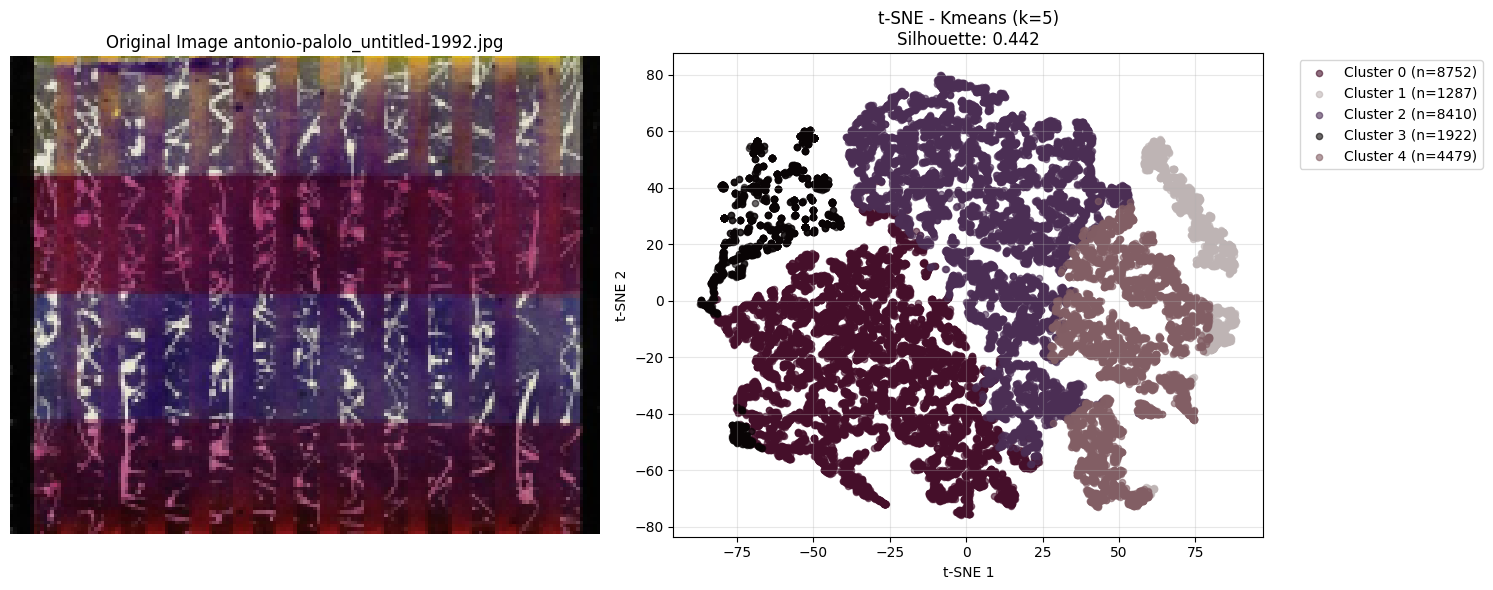

t-SNE completed:
  - Perplexity used: 30


/Users/I864098/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 32200 samples in 0.004s...
[t-SNE] Computed neighbors for 32200 samples in 0.230s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32200
[t-SNE] Computed conditional probabilities for sample 2000 / 32200
[t-SNE] Computed conditional probabilities for sample 3000 / 32200
[t-SNE] Computed conditional probabilities for sample 4000 / 32200
[t-SNE] Computed conditional probabilities for sample 5000 / 32200
[t-SNE] Computed conditional probabilities for sample 6000 / 32200
[t-SNE] Computed conditional probabilities for sample 7000 / 32200
[t-SNE] Computed conditional probabilities for sample 8000 / 32200
[t-SNE] Computed conditional probabilities for sample 9000 / 32200
[t-SNE] Computed conditional probabilities for sample 10000 / 32200
[t-SNE] Computed conditional probabilities for sample 11000 / 32200
[t-SNE] Computed conditional probabilities for sample 12000 / 32200
[t-SNE] Computed conditional probabilities for sam

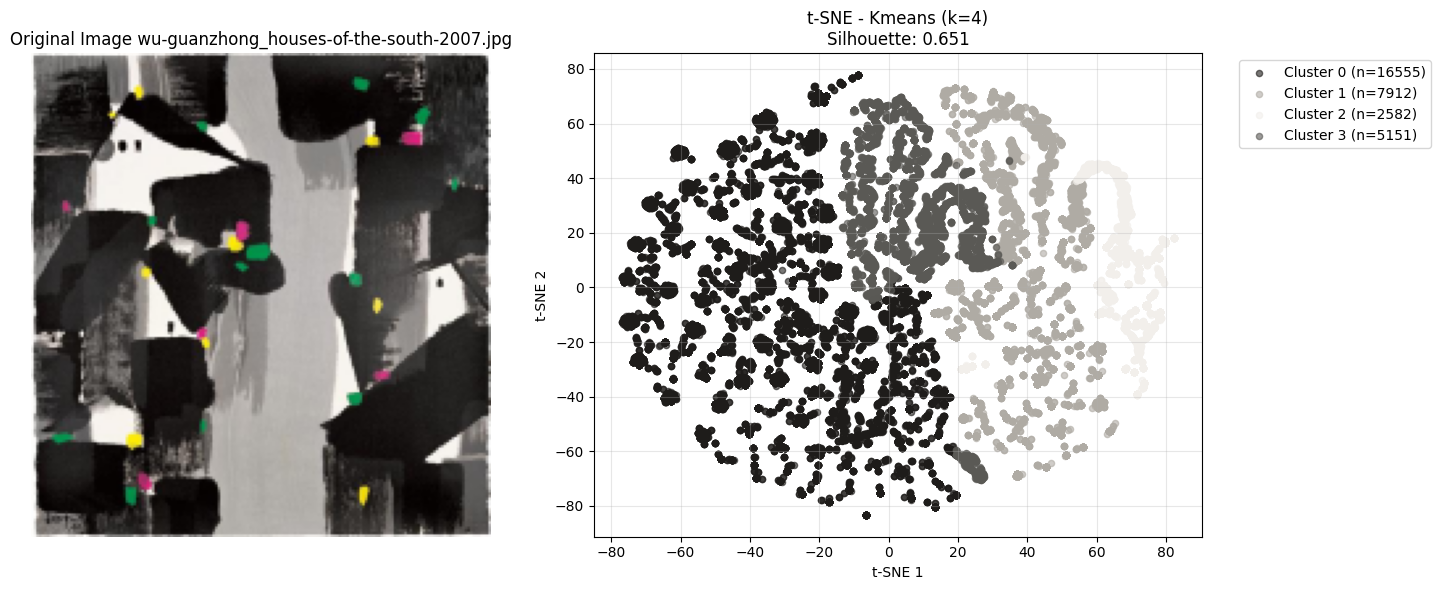

t-SNE completed:
  - Perplexity used: 30


/Users/I864098/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 34444 samples in 0.005s...
[t-SNE] Computed neighbors for 34444 samples in 0.351s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34444
[t-SNE] Computed conditional probabilities for sample 2000 / 34444
[t-SNE] Computed conditional probabilities for sample 3000 / 34444
[t-SNE] Computed conditional probabilities for sample 4000 / 34444
[t-SNE] Computed conditional probabilities for sample 5000 / 34444
[t-SNE] Computed conditional probabilities for sample 6000 / 34444
[t-SNE] Computed conditional probabilities for sample 7000 / 34444
[t-SNE] Computed conditional probabilities for sample 8000 / 34444
[t-SNE] Computed conditional probabilities for sample 9000 / 34444
[t-SNE] Computed conditional probabilities for sample 10000 / 34444
[t-SNE] Computed conditional probabilities for sample 11000 / 34444
[t-SNE] Computed conditional probabilities for sample 12000 / 34444
[t-SNE] Computed conditional probabilities for sam

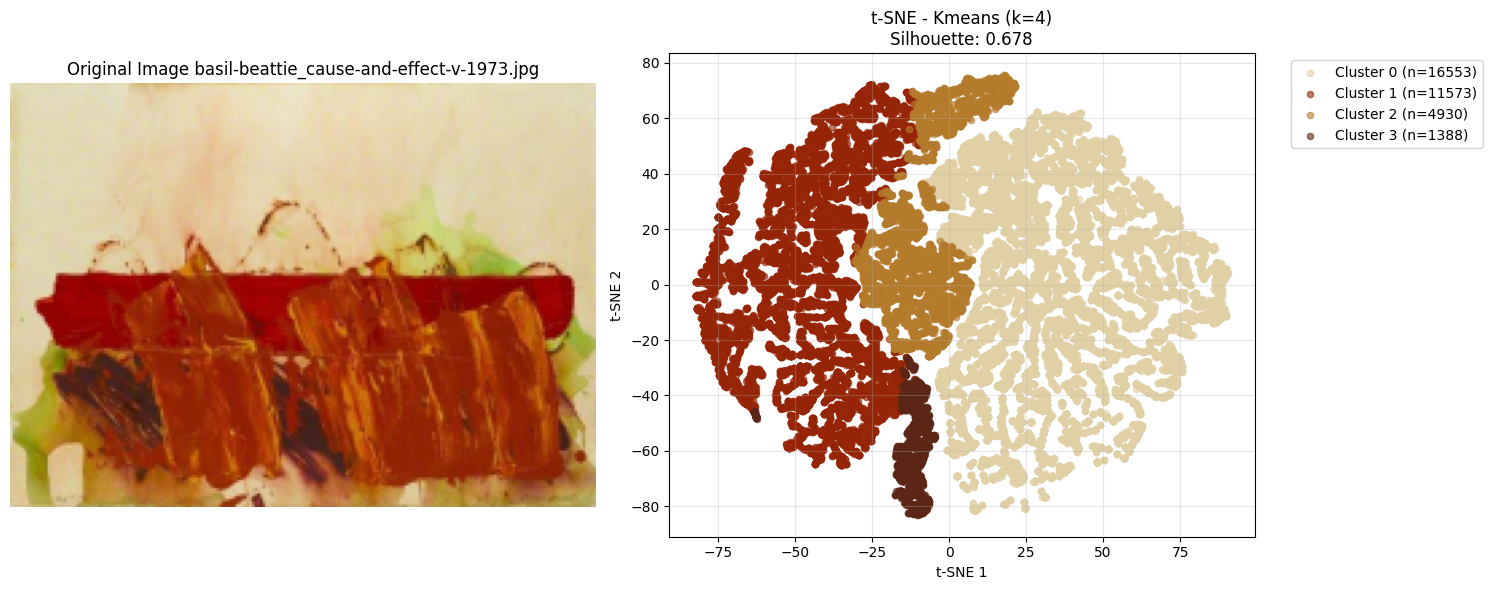

t-SNE completed:
  - Perplexity used: 30


/Users/I864098/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 24150 samples in 0.003s...
[t-SNE] Computed neighbors for 24150 samples in 0.224s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24150
[t-SNE] Computed conditional probabilities for sample 2000 / 24150
[t-SNE] Computed conditional probabilities for sample 3000 / 24150
[t-SNE] Computed conditional probabilities for sample 4000 / 24150
[t-SNE] Computed conditional probabilities for sample 5000 / 24150
[t-SNE] Computed conditional probabilities for sample 6000 / 24150
[t-SNE] Computed conditional probabilities for sample 7000 / 24150
[t-SNE] Computed conditional probabilities for sample 8000 / 24150
[t-SNE] Computed conditional probabilities for sample 9000 / 24150
[t-SNE] Computed conditional probabilities for sample 10000 / 24150
[t-SNE] Computed conditional probabilities for sample 11000 / 24150
[t-SNE] Computed conditional probabilities for sample 12000 / 24150
[t-SNE] Computed conditional probabilities for sam

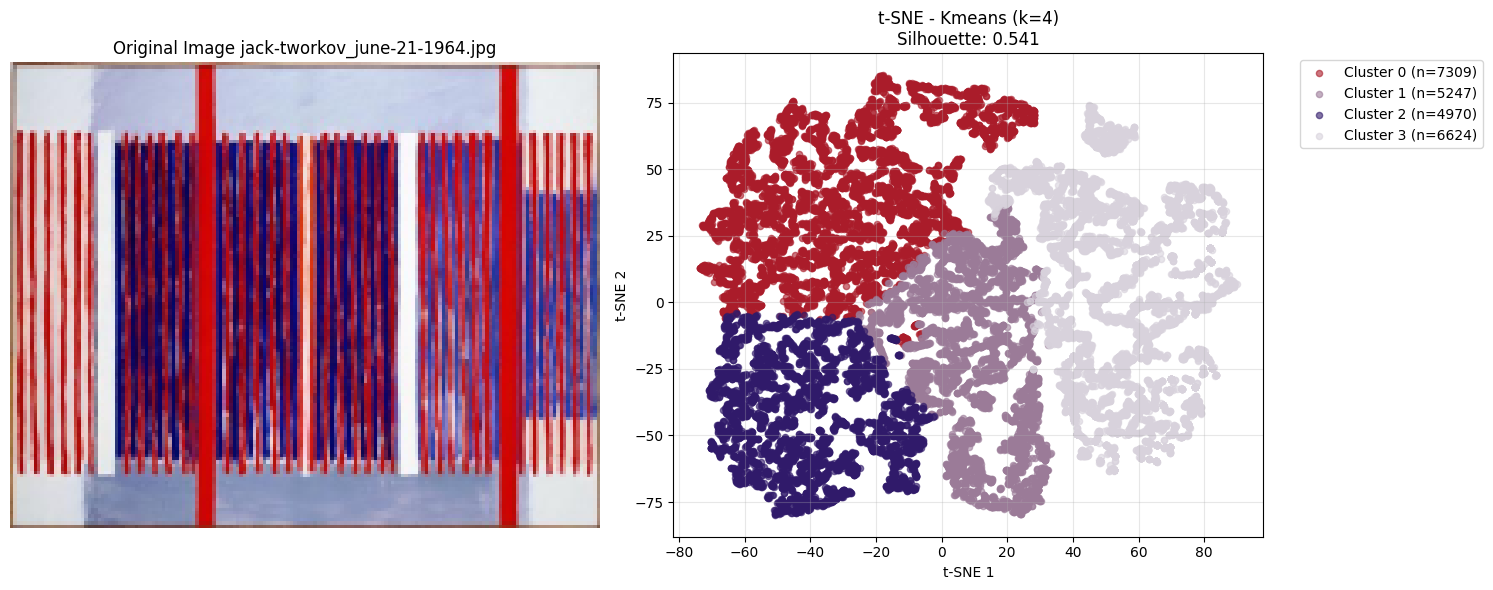

t-SNE completed:
  - Perplexity used: 30
K-Means t-SNE completed successfully


In [25]:
kmeans_tsne_pipeline = Pipeline(
    steps=[("image_load", ImageUtilities(scale_percent=SCALE_PERCENT)
            ), ('tsne_plot', TSNEPlot(method='kmeans', perplexity=30))])

print("=== K-Means t-SNE Visualization ===")
kmedoids_tsne_results = kmeans_tsne_pipeline.fit_transform(images_clustering)
print("K-Means t-SNE completed successfully")